In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

def resize_pair(image, mask, target_width=512, target_height=512):
    """
    Resizes a fundus image and its corresponding mask to a specific resolution.
    
    Args:
        image (np.array): The RGB fundus photo.
        mask (np.array): The binary mask (uint8 or bool).
        target_width (int): Desired width.
        target_height (int): Desired height.
        
    Returns:
        tuple: (resized_image, resized_mask)
    """
    dsize = (target_width, target_height)
    
    # 1. Resize Image
    # cv2.INTER_AREA is best for downscaling (e.g. 2000x2000 -> 512x512) to avoid aliasing.
    # cv2.INTER_LINEAR is standard for upscaling.
    img_resized = cv2.resize(image, dsize, interpolation=cv2.INTER_AREA)
    
    # 2. Resize Mask
    # MUST use cv2.INTER_NEAREST to preserve binary values (0/1). 
    # Other methods will introduce gradients at the edges.
    mask_to_resize = mask.astype(np.uint8) # Ensure it's numeric for OpenCV
    mask_resized = cv2.resize(mask_to_resize, dsize, interpolation=cv2.INTER_NEAREST)
    
    # If your input was boolean, cast it back
    if mask.dtype == bool:
        mask_resized = mask_resized.astype(bool)
        
    return img_resized, mask_resized

def get_boolean_mask_from_contour(contour_path, height, width):
    """
    Generates a Boolean mask (True/False) from a contour text file.
    
    Returns:
        np.ndarray: A boolean matrix of shape (height, width).
                    True indicates the region inside the contour.
    """
    # 1. Load data
    try:
        contour_data = np.loadtxt(contour_path)
    except Exception as e:
        raise IOError(f"Could not read contour file: {e}")

    # 2. Prepare points for OpenCV (requires integer coordinates)
    points = contour_data.astype(np.int32)
    points = points.reshape((-1, 1, 2))

    # 3. Create a temporary numeric mask (OpenCV needs uint8, not bool)
    temp_mask = np.zeros((height, width), dtype=np.uint8)
    
    # 4. Fill the polygon with a non-zero value (e.g., 1 or 255)
    cv2.fillPoly(temp_mask, [points], color=1)

    # 5. Convert to Boolean
    # Any non-zero value becomes True, 0 becomes False
    boolean_mask = temp_mask.astype(bool)

    return boolean_mask

def get_mask_from_contour(contour_path, height, width):
    """
    Helper function: Reads contour coordinates and generates a binary mask.
    """
    # 1. Load data
    try:
        contour_data = np.loadtxt(contour_path)
    except Exception as e:
        raise IOError(f"Could not read contour file: {e}")

    # 2. Check data validity
    if contour_data.ndim != 2 or contour_data.shape[1] != 2:
        raise ValueError("Contour file must contain 2 columns (x, y).")

    # 3. Convert to integer points for OpenCV
    points = contour_data.astype(np.int32)
    points = points.reshape((-1, 1, 2))

    # 4. Create and fill mask
    mask = np.zeros((height, width), dtype=np.uint8)
    cv2.fillPoly(mask, [points], color=255)

    return mask

def process_fundus_contour(image_path, contour_path, show_plot=True):
    """
    Main driver: Loads the image, calls the mask generator, and visualizes the result.
    """
    # 1. Load the Image
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None, None

    # Load image and convert BGR -> RGB for Matplotlib
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print("Error: Failed to decode image.")
        return None, None
        
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    h, w, _ = img_rgb.shape

    # 2. Get the Mask (Refactored call)
    try:
        mask = get_mask_from_contour(contour_path, h, w)
    except Exception as e:
        print(f"Error generating mask: {e}")
        return None, None

    # 3. Visualization
    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot Original
        axes[0].imshow(img_rgb)
        axes[0].set_title("Original Fundus Image")
        axes[0].axis('off')
        
        # Plot Mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title("Binary Mask")
        axes[1].axis('off')
        
        # Plot Overlay
        axes[2].imshow(img_rgb)
        axes[2].imshow(mask, cmap='Greens', alpha=0.4) # Green overlay
        
        # Optional: Plot the specific contour line
        contour_data = np.loadtxt(contour_path)
        # Close the loop for the line plot
        x_plot = np.append(contour_data[:, 0], contour_data[0, 0])
        y_plot = np.append(contour_data[:, 1], contour_data[0, 1])
        axes[2].plot(x_plot, y_plot, 'r--', linewidth=1.5)
        
        axes[2].set_title("Segmentation Overlay")
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()

    # return img_rgb, mask

def process_fundus_mask(img, mask, show_plot=True):
    """
    Visualizes a loaded fundus image and its corresponding binary mask.

    Args:
        img (np.array): The RGB fundus image (H, W, 3).
        mask (np.array): The binary mask (H, W), either boolean or uint8 (0-255).
        show_plot (bool): Whether to display the plot.
    """
    # 1. Validation
    if img is None or mask is None:
        print("Error: Image or Mask is None.")
        return

    # 2. Normalize Mask for Visualization (Ensure uint8 0-255)
    if mask.dtype == bool:
        mask_viz = mask.astype(np.uint8) * 255
    else:
        mask_viz = mask.astype(np.uint8)
        # If mask is 0-1, scale to 0-255
        if mask_viz.max() <= 1 and mask_viz.max() > 0:
            mask_viz *= 255

    # 3. Visualization
    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # --- Panel 1: Original Image ---
        axes[0].imshow(img)
        axes[0].set_title("Fundus Image")
        axes[0].axis('off')

        # --- Panel 2: Binary Mask ---
        axes[1].imshow(mask_viz, cmap='gray')
        axes[1].set_title("Binary Mask")
        axes[1].axis('off')

        # --- Panel 3: Overlay ---
        axes[2].imshow(img)
        # Overlay green mask with transparency
        axes[2].imshow(mask_viz, cmap='Greens', alpha=0.4)

        # Dynamic Contour Drawing:
        # Since we don't have the text file anymore, we calculate the contour 
        # from the mask itself to draw the red outline.
        contours, _ = cv2.findContours(mask_viz, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        for contour in contours:
            # contour shape is (N, 1, 2) -> we need (N, 2)
            pts = contour.reshape(-1, 2)
            # Close the loop
            pts = np.vstack([pts, pts[0]])
            axes[2].plot(pts[:, 0], pts[:, 1], 'r-', linewidth=1.5)

        axes[2].set_title("Segmentation Overlay")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

def process_fundus_mask_save(img, mask, save_dir=None, filename_prefix="image", show_plot=True):
    """
    Visualizes a fundus image and mask, and saves the three images to a folder.
    Ensures the saved overlay looks exactly like the Matplotlib plot.
    """
    # 1. Validation
    if img is None or mask is None:
        print("Error: Image or Mask is None.")
        return

    # 2. Normalize Mask (Ensure uint8 0-255)
    if mask.dtype == bool:
        mask_viz = mask.astype(np.uint8) * 255
    else:
        mask_viz = mask.astype(np.uint8)
        if mask_viz.max() <= 1 and mask_viz.max() > 0:
            mask_viz *= 255

    # 3. Calculate Contours
    contours, _ = cv2.findContours(mask_viz, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # --- Helper: Define overlay plotting logic once to ensure consistency ---
    def plot_final_overlay(target_axis):
        """Applies the exact visual styles to a given Matplotlib axis."""
        target_axis.imshow(img)
        # The exact line from your example
        target_axis.imshow(mask_viz, cmap='Greens', alpha=0.4)
        
        # The exact contour drawing logic
        for contour in contours:
            pts = contour.reshape(-1, 2)
            pts = np.vstack([pts, pts[0]])
            target_axis.plot(pts[:, 0], pts[:, 1], 'r-', linewidth=1.5)
        target_axis.axis('off')

    # ---------------------------------------------------------
    # 4. Save Images (If directory is provided)
    # ---------------------------------------------------------
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        print(f"Saving images to: {save_dir}")
        
        # A. Save Original (Convert RGB -> BGR for OpenCV)
        path_orig = os.path.join(save_dir, f"{filename_prefix}_original.png")
        cv2.imwrite(path_orig, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

        # B. Save Binary Mask
        path_mask = os.path.join(save_dir, f"{filename_prefix}_mask.png")
        cv2.imwrite(path_mask, mask_viz)

        # C. Save Overlay (Using Matplotlib renderer for exact match)
        path_overlay = os.path.join(save_dir, f"{filename_prefix}_overlay.png")
        
        # Create a temporary figure designed to have NO margins/borders
        h, w, _ = img.shape
        # Set figure size to match image aspect ratio
        fig_temp = plt.figure(frameon=False)
        fig_temp.set_size_inches(w / 100, h / 100) # Assuming 100 DPI base
        
        # Add an axis that fills the entire figure exactly [left, bottom, width, height]
        ax_temp = fig_temp.add_axes([0, 0, 1, 1])
        
        # Apply the plotting logic to this temp axis
        plot_final_overlay(ax_temp)
        
        # Save the temporary figure using the dimensions defined above
        fig_temp.savefig(path_overlay, dpi=100)
        # Close the temp figure so it doesn't show up later
        plt.close(fig_temp) 
        
        print("Saved successfully.")

    # ---------------------------------------------------------
    # 5. Visualization (Main Plot)
    # ---------------------------------------------------------
    if show_plot:
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Panel 1: Original
        axes[0].imshow(img)
        axes[0].set_title("Fundus Image")
        axes[0].axis('off')

        # Panel 2: Mask
        axes[1].imshow(mask_viz, cmap='gray')
        axes[1].set_title("Binary Mask")
        axes[1].axis('off')

        # Panel 3: Overlay
        # Re-use the exact same helper function
        plot_final_overlay(axes[2])
        axes[2].set_title("Segmentation Overlay") # Add title only for display version

        plt.tight_layout()
        plt.show()

def load_mask_as_boolean(mask_path, threshold=127):
    """
    Loads a mask image file and converts it to a boolean matrix.

    Args:
        mask_path (str): Path to the image file (e.g., .png, .jpg).
        threshold (int): Pixel value cutoff. Values > threshold become True. 
                         Default 127 handles standard 0 vs 255 binary masks well.

    Returns:
        np.ndarray: A boolean matrix (True/False) with the same height/width as the file.
    """
    if not os.path.exists(mask_path):
        raise FileNotFoundError(f"Mask file not found: {mask_path}")

    # 1. Read the image as Grayscale
    # This ensures we get a 2D array (H, W) immediately, ignoring color channels.
    mask_img = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if mask_img is None:
        raise ValueError(f"Failed to decode image file: {mask_path}")

    # 2. Convert to Boolean
    # We use a threshold comparison rather than direct casting (.astype(bool))
    # to be safe against JPEG compression artifacts (where 0 might become 1 or 2).
    mask_bool = mask_img > threshold

    return mask_bool


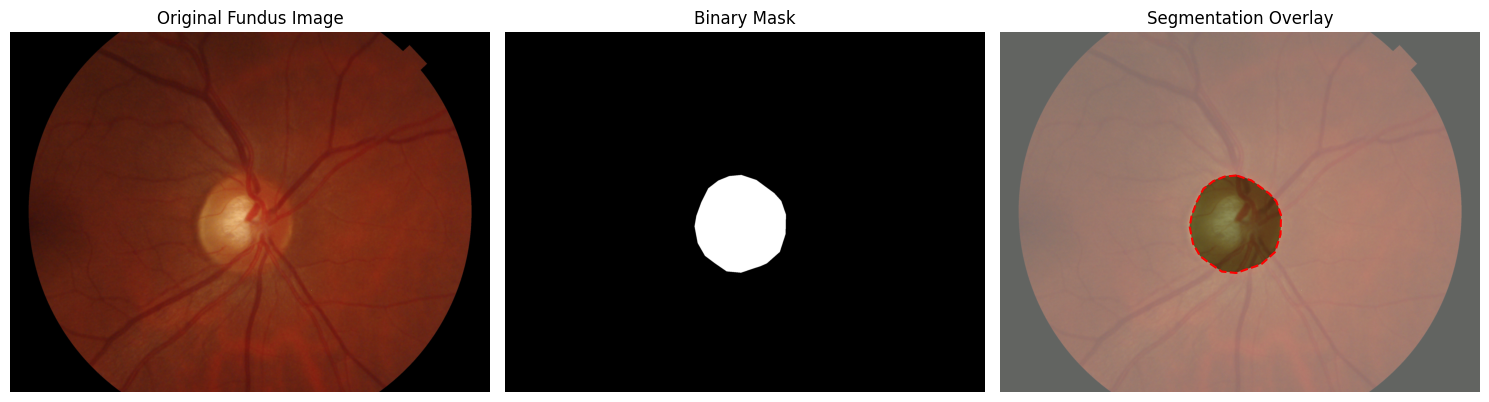

In [9]:
input_img = "/PHShome/yl535/project/python/datasets/PAPILA/FundusImages/RET002OD.jpg"
input_contour = "/PHShome/yl535/project/python/datasets/PAPILA/ExpertsSegmentations/Contours/RET002OD_disc_exp1.txt"

# 3. Run the function
process_fundus_contour(input_img, input_contour)

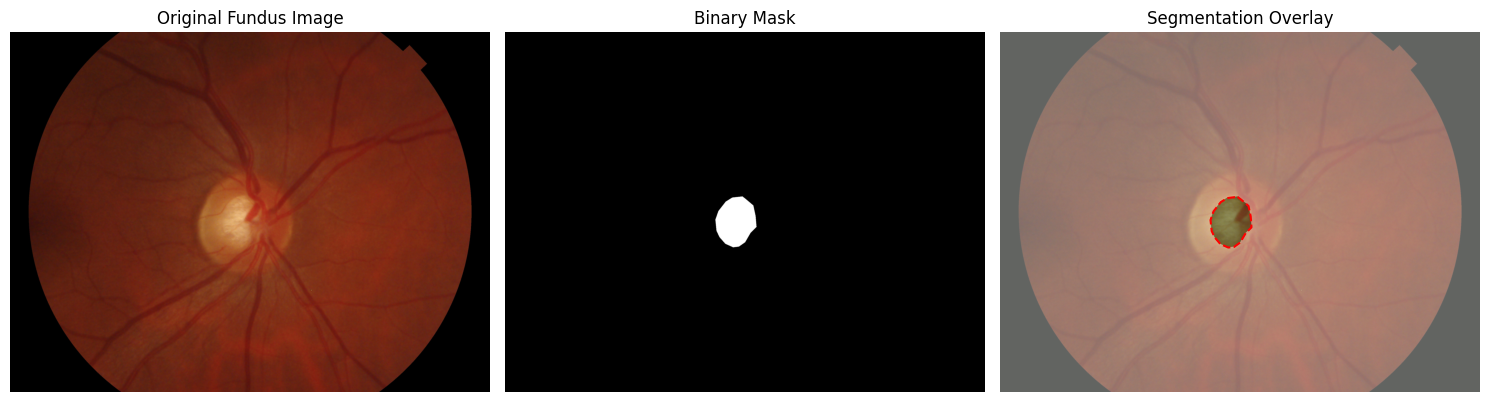

In [10]:
input_img = "/PHShome/yl535/project/python/datasets/PAPILA/FundusImages/RET002OD.jpg"
input_contour = "/PHShome/yl535/project/python/datasets/PAPILA/ExpertsSegmentations/Contours/RET002OD_cup_exp1.txt"

# 3. Run the function
process_fundus_contour(input_img, input_contour)

<class 'numpy.ndarray'> (2048, 2048, 3) <class 'numpy.ndarray'> (2048, 2048)
False True [False  True]


Saved: /PHShome/yl535/project/python/sam_3d/sam-3d-objects/data4paper/100_D_original.png, /PHShome/yl535/project/python/sam_3d/sam-3d-objects/data4paper/100_D_mask.png, /PHShome/yl535/project/python/sam_3d/sam-3d-objects/data4paper/100_D_overlay.png


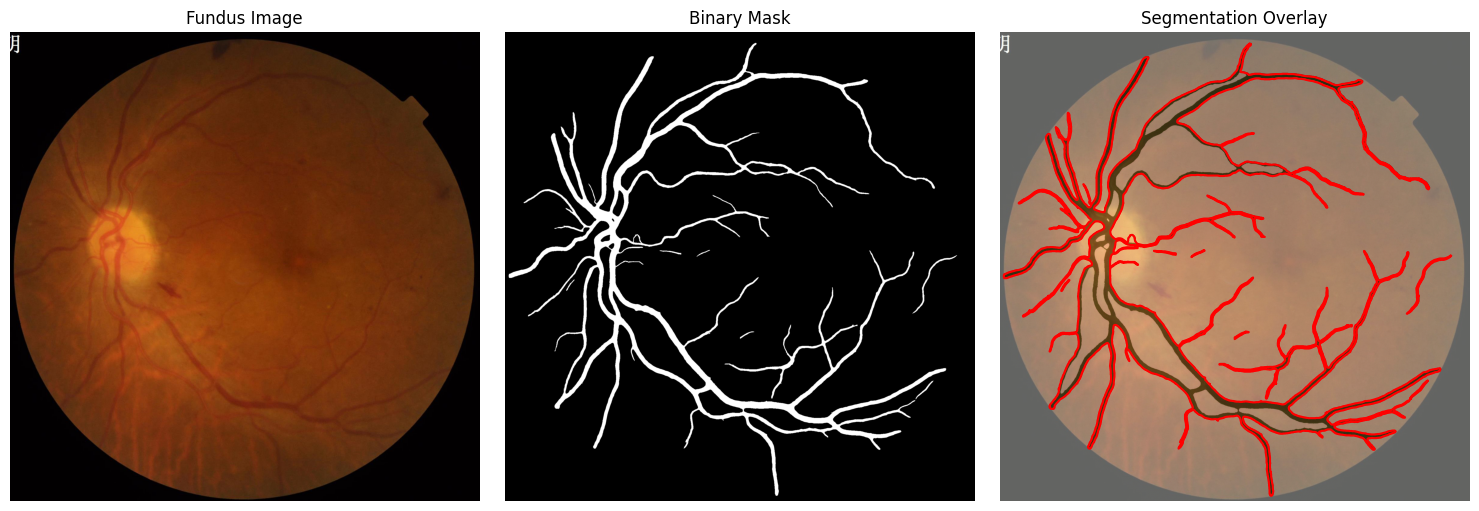

In [3]:
input_img = "/PHShome/yl535/project/python/datasets/Fundus_Image_Vessel_Segmentation/test/Original/100_D.png"
input_mask = "/PHShome/yl535/project/python/datasets/Fundus_Image_Vessel_Segmentation/test/Ground_truth/100_D.png"

filename = os.path.basename(input_img)
base_name = filename.split('.png')[0] 

img_bgr = cv2.imread(input_img)
if img_bgr is None:
    print("Error: Failed to decode image.")
    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = img_rgb.shape

mask = load_mask_as_boolean(input_mask)

print(type(img_rgb), img_rgb.shape, type(mask), mask.shape)
print(np.min(mask), np.max(mask), np.unique(mask))

# 3. Run the function
# process_fundus_mask(img_rgb, mask)
process_fundus_mask_save(img_rgb, mask, save_dir="/PHShome/yl535/project/python/sam_3d/sam-3d-objects/data4paper", filename_prefix=base_name)

<class 'numpy.ndarray'> (2048, 2048, 3) <class 'numpy.ndarray'> (2048, 2048)
False True [False  True]


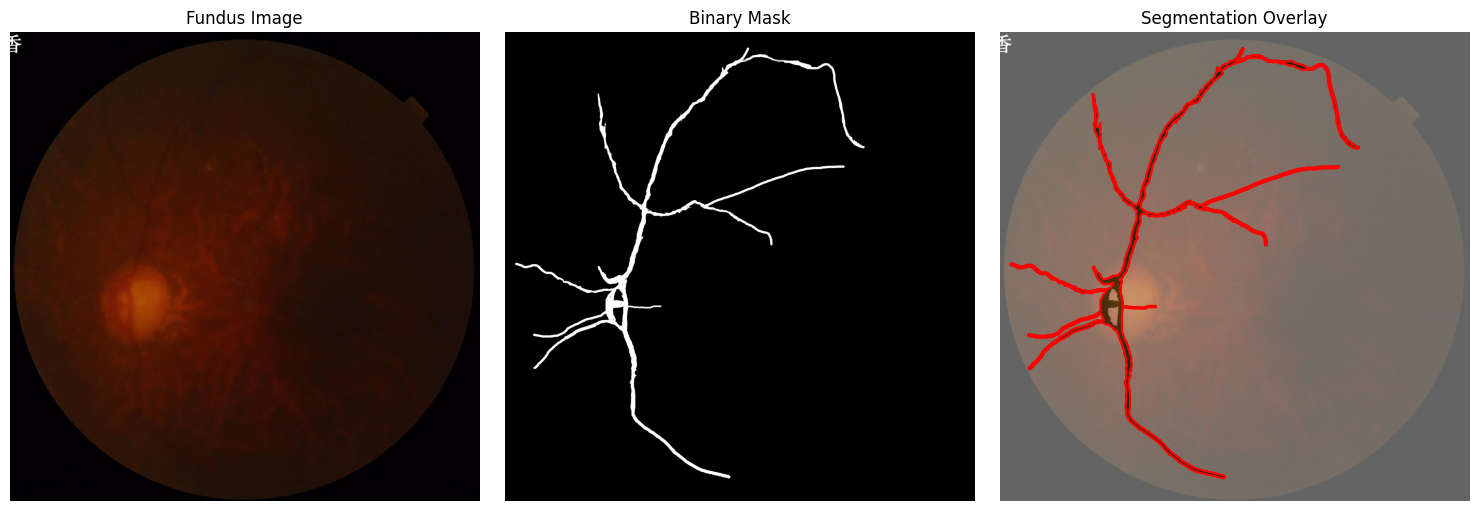

In [7]:
input_img = "/PHShome/yl535/project/python/datasets/Fundus_Image_Vessel_Segmentation/test/Original/136_G.png"
input_mask = "/PHShome/yl535/project/python/datasets/Fundus_Image_Vessel_Segmentation/test/Ground_truth/136_G.png"

img_bgr = cv2.imread(input_img)
if img_bgr is None:
    print("Error: Failed to decode image.")
    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = img_rgb.shape

mask = load_mask_as_boolean(input_mask)

print(type(img_rgb), img_rgb.shape, type(mask), mask.shape)
print(np.min(mask), np.max(mask), np.unique(mask))

# 3. Run the function
process_fundus_mask(img_rgb, mask)

In [6]:
mask_to_resize = mask.astype(np.uint8) # Ensure it's numeric for OpenCV
mask_resized = cv2.resize(mask_to_resize, (512,512), interpolation=cv2.INTER_NEAREST)

# If your input was boolean, cast it back
if mask.dtype == bool:
    mask_resized = mask_resized.astype(bool)

print(np.min(mask_resized), np.max(mask_resized), np.unique(mask_resized))

False True [False  True]


In [3]:
import os
import imageio
import uuid
from IPython.display import Image as ImageDisplay
from inference import Inference, ready_gaussian_for_video_rendering, render_video, load_image, load_single_mask, display_image, make_scene, interactive_visualizer

import torch
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
from transformers import pipeline
from io import BytesIO

def show_masks(image, masks):
    """
    Helper function to display the image with masks overlaid.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Iterate through each mask and overlay it
    for mask in masks:
        # Convert PIL mask to numpy array (boolean)
        m = np.array(mask) > 0 
        
        # Generate a random color for this mask
        color = np.concatenate([np.random.random(3), [0.6]]) # [R, G, B, Alpha]
        
        # Create a colored mask image
        h, w = m.shape
        mask_image = m.reshape(h, w, 1) * color.reshape(1, 1, -1)
        
        # Overlay the mask
        ax.imshow(mask_image)

    plt.axis('off')
    plt.show()

/shared/ssd_28T/home/yl535/anaconda3/envs/sam3d-objects/lib/python3.11/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
Warp CUDA error 2: out of memory (in function wp_cuda_device_get_memory_info, /builds/omniverse/warp/warp/native/warp.cu:2231)
Warp CUDA error 201: invalid device context (in function wp_cuda_device_get_memory_info, /builds/omniverse/warp/warp/native/warp.cu:2234)
Warp CUDA error 201: invalid device context (in function wp_cuda_device_get_memory_info, /builds/omniverse/warp/warp/native/warp.cu:2236)
Warp CUDA error 2: out of memory (in function wp_cuda_device_get_memory_info, /builds/omniverse/warp/warp/native/warp.cu:2231)
Warp CUDA error 201: invalid device context (in function wp_cuda_device_get_memory_info, /builds/omniverse/w

Warp 1.10.0 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
     "cuda:1"   : "NVIDIA H100 80GB HBM3" (0 GiB, sm_90, mempool enabled)
     "cuda:2"   : "NVIDIA H100 80GB HBM3" (0 GiB, sm_90, mempool enabled)
     "cuda:3"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
     "cuda:4"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
     "cuda:5"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
     "cuda:6"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
     "cuda:7"   : "NVIDIA H100 80GB HBM3" (79 GiB, sm_90, mempool enabled)
   CUDA peer access:
     Supported fully (all-directional)
   Kernel cache:
     /PHShome/yl535/.cache/warp/1.10.0


2025-12-04 15:00:48.336 | INFO     | sam3d_objects.pipeline.inference_pipeline:set_attention_backend:15 - GPU name is NVIDIA H100 80GB HBM3


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2025-12-04 15:00:50.294 | INFO     | sam3d_objects.model.backbone.tdfy_dit.modules.sparse:__from_env:39 - [SPARSE] Backend: spconv, Attention: flash_attn
2025-12-04 15:00:54.398 | INFO     | sam3d_objects.model.backbone.tdfy_dit.modules.attention:__from_env:30 - [ATTENTION] Using backend: flash_attn


[SPARSE][CONV] spconv algo: auto


2025-12-04 15:00:54.637 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
2025-12-04 15:00:54.638 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 


In [4]:
PATH = os.getcwd()
TAG = "hf"
# config_path = f"{PATH}/../checkpoints/{TAG}/pipeline.yaml"
config_path = f"{PATH}/../checkpoints/checkpoints/pipeline.yaml"
inference = Inference(config_path, compile=False)

device = 3 if torch.cuda.is_available() else -1
generator = pipeline(
    "mask-generation", 
    model="facebook/sam2-hiera-large", 
    device=device,
    torch_dtype=torch.float32 
)

2025-12-04 15:00:54.836 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
/shared/ssd_28T/home/yl535/anaconda3/envs/sam3d-objects/lib/python3.11/site-packages/moge/model/v1.py:171: UserWarning: The following deprecated/invalid arguments are ignored: {'output_mask': True, 'split_head': True}
  warnings.warn(f"The following deprecated/invalid arguments are ignored: {deprecated_kwargs}")
2025-12-04 15:01:00.952 | WARNING  | sam3d_objects.data.dataset.tdfy.preprocessor:__post_init__:51 - No rgb pointmap normalizer provided, using scale + shift 
2025-12-04 15:01:00.954 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:98 - self.device: cuda
2025-12-04 15:01:00.954 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:99 - CUDA_VISIBLE_DEVICES: None
2025-12-04 15:01:00.954 | INFO     | sam3d_objects.pipeline.inference_pipeline:__init__:100 - Actually using GPU: 0
2025-12-04 15:01:00.9

1934 2576


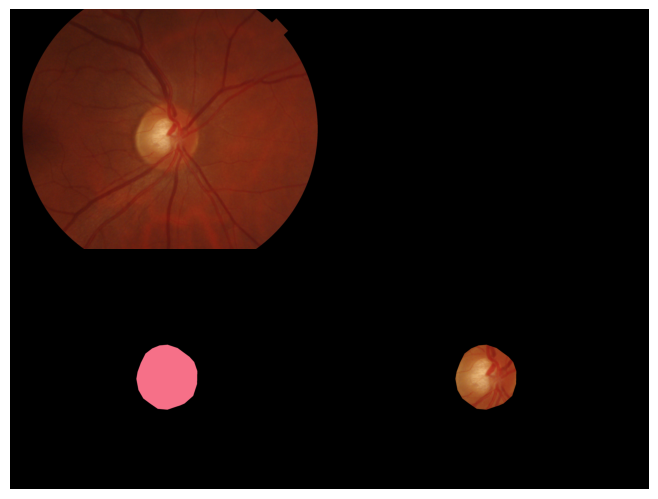

In [5]:
input_img = "/PHShome/yl535/project/python/datasets/PAPILA/FundusImages/RET002OD.jpg"
input_contour = "/PHShome/yl535/project/python/datasets/PAPILA/ExpertsSegmentations/Contours/RET002OD_disc_exp1.txt"

filename = os.path.basename(input_img)
base_name = filename.split('.jpg')[0] 

# Load image and convert BGR -> RGB for Matplotlib
img_bgr = cv2.imread(input_img)
if img_bgr is None:
    print("Error: Failed to decode image.")
    
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w, _ = img_rgb.shape
print(h, w)

# 2. Get the Mask (Refactored call)
try:
    mask = get_boolean_mask_from_contour(input_contour, h, w)
except Exception as e:
    print(f"Error generating mask: {e}")

# print(type(img_rgb), img_rgb.shape, type(mask), mask.shape)
# print(np.min(mask), np.max(mask), np.unique(mask))
display_image(img_rgb, masks=[mask])

In [6]:
output_dir = f"{PATH}/../results/gaussians/"
os.makedirs(output_dir, exist_ok=True)
# run model
rz_img, rz_mask = resize_pair(img_rgb, mask)
output = inference(rz_img, rz_mask, seed=42)

# export gaussian splat (as point cloud)
output["gs"].save_ply(os.path.join(output_dir, f"{base_name}.ply"))

2025-12-04 15:01:39.060 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_sparse_structure:662 - Sampling sparse structure: inference_steps=25, strength=7, interval=[0, 500], rescale_t=3, cfg_strength_pm=0.0
2025-12-04 15:01:39.061 | INFO     | sam3d_objects.pipeline.inference_pipeline:get_condition_input:631 - Running condition embedder ...
2025-12-04 15:01:39.250 | INFO     | sam3d_objects.pipeline.inference_pipeline:get_condition_input:635 - Condition embedder finishes!
2025-12-04 15:01:43.921 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_sparse_structure:712 - Downsampled coords from 7041 to 7041
2025-12-04 15:01:43.970 | INFO     | sam3d_objects.pipeline.inference_pipeline_pointmap:run:368 - Rescaling scale by 1 after downsampling
2025-12-04 15:01:43.970 | INFO     | sam3d_objects.pipeline.inference_pipeline:sample_slat:742 - Sampling sparse latent: inference_steps=25, strength=1, interval=[0, 500], rescale_t=1
2025-12-04 15:01:43.971 | INFO     | sam3d

OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacity of 79.11 GiB of which 927.25 MiB is free. Process 2314397 has 29.75 GiB memory in use. Process 1961923 has 28.92 GiB memory in use. Process 1493134 has 2.65 GiB memory in use. Including non-PyTorch memory, this process has 16.85 GiB memory in use. Of the allocated memory 15.66 GiB is allocated by PyTorch, and 270.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# render gaussian splat
scene_gs = make_scene(output)
scene_gs = ready_gaussian_for_video_rendering(scene_gs)

video = render_video(
    scene_gs,
    r=1,
    fov=60,
    pitch_deg=15,
    yaw_start_deg=-45,
    resolution=512,
)["color"]

# save video as gif
imageio.mimsave(
    os.path.join(f"{PATH}/gaussians/single/{IMAGE_NAME}.gif"),
    video,
    format="GIF",
    duration=1000 / 30,  # default assuming 30fps from the input MP4
    loop=0,  # 0 means loop indefinitely
)

# notebook display
ImageDisplay(url=f"gaussians/single/{IMAGE_NAME}.gif?cache_invalidator={uuid.uuid4()}")

In [7]:
input_gif = "/PHShome/yl535/project/python/sam_3d/sam-3d-objects/results/gaussians/RET002OD_disc.gif"
ImageDisplay(url=f"{input_gif}?cache_invalidator={uuid.uuid4()}")

In [ ]:
input_gif = "/PHShome/yl535/project/python/sam_3d/sam-3d-objects/results/gaussians/RET002OD_disc.gif"
ImageDisplay(url=f"{input_gif}?cache_invalidator={uuid.uuid4()}")